In [1]:
import matplotlib.pyplot as plt

import numpy as np

import json
import glob
import sys
import os

sys.path.append('../src')

### Visualization of training loss and test accuracy

In [2]:
with open('../experiments/history/history-AConvNet-SOC.json') as f:
    history = json.load(f)

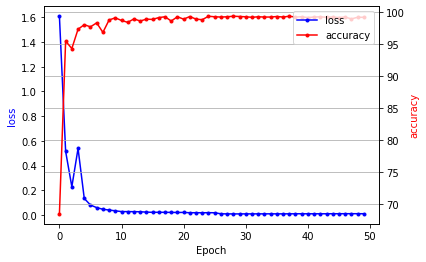

In [3]:
training_loss = history['loss']
test_accuracy = history['accuracy']

epochs = np.arange(len(training_loss))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

plot1, = ax1.plot(epochs, training_loss, marker='.', c='blue', label='loss')
plot2, = ax2.plot(epochs, test_accuracy, marker='.', c='red', label='accuracy')
plt.legend([plot1, plot2], ['loss', 'accuracy'], loc='upper right')

plt.grid()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss', color='blue')
ax2.set_ylabel('accuracy', color='red')
plt.show()


### Early Stopping

In [4]:
from tqdm import tqdm
import torchvision
import torch

from utils import common
from data import loader
import model

In [5]:
def load_dataset(path, is_train, name, batch_size):

    _dataset = loader.Dataset(
        path, name=name, is_train=is_train,
        transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    )
    data_loader = torch.utils.data.DataLoader(
        _dataset, batch_size=batch_size, shuffle=is_train, num_workers=1
    )
    return data_loader


def evaluate(_m, ds):
    
    num_data = 0
    corrects = 0
    
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels = data

        predictions = _m.inference(images)
        predictions = _softmax(predictions)

        _, predictions = torch.max(predictions.data, 1)
        labels = labels.type(torch.LongTensor)
        num_data += labels.size(0)
        corrects += (predictions == labels.to(m.device)).sum().item()

    accuracy = 100 * corrects / num_data
    return accuracy

In [6]:

config = common.load_config(os.path.join(common.project_root, 'experiments/config/AConvNet-SOC.json'))
model_name = config['model_name']
test_set = load_dataset('dataset', False, 'soc', 100)

m = model.Model(
    classes=config['num_classes'], channels=config['channels'],
)

model_history = glob.glob(os.path.join(common.project_root, f'experiments/model/{model_name}/*.pth'))
model_history = sorted(model_history, key=os.path.basename)

best = {
    'epoch': 0,
    'accuracy': 0,
    'path': ''
}

for i, model_path in enumerate(model_history):
    m.load(model_path)
    accuracy = evaluate(m, test_set)
    if accuracy > best['accuracy']:
        best['epoch'] = i
        best['accuracy'] = accuracy
        best['path'] = model_path
        print(f'Best accuracy at epoch={i} with {accuracy:.2f}%')
    
best_epoch = best['epoch']
best_accuracy = best['accuracy']
best_path = best['path']

print(f'Final model is epoch={best_epoch} with accurayc={best_accuracy:.2f}%')
print(f'Path={best_path}')

load test data set: 2425it [00:01, 2208.65it/s]
d:\ivs\project\004-research\signal-processing\image-processing\remote-sensing\aconvnet\aconvnet-pytorch\venv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Best accuracy at epoch=0 with 68.49%
Best accuracy at epoch=1 with 95.42%
Best accuracy at epoch=3 with 97.28%
Best accuracy at epoch=4 with 97.98%
Best accuracy at epoch=6 with 98.27%
Best accuracy at epoch=8 with 98.72%
Best accuracy at epoch=9 with 99.05%
Best accuracy at epoch=16 with 99.09%
Best accuracy at epoch=17 with 99.22%
Best accuracy at epoch=21 with 99.26%
Best accuracy at epoch=24 with 99.30%
Final model is epoch=24 with accurayc=99.30%
Path=D:\ivs\Project\004-research\signal-processing\image-processing\remote-sensing\aconvnet\AConvNet-pytorch\experiments/model/AConvNet-SOC\model-025.pth


### Confusion Matrix with Best Model

In [7]:
from sklearn import metrics
from data import mstar

def confusion_matrix(_m, ds):
    _pred = []
    _gt = []
    
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels = data
        
        predictions = _m.inference(images)
        predictions = _softmax(predictions)

        _, predictions = torch.max(predictions.data, 1)
        labels = labels.type(torch.LongTensor)
        
        _pred += predictions.cpu().tolist()
        _gt += labels.cpu().tolist()
        
    conf_mat = metrics.confusion_matrix(_gt, _pred)
        
    return conf_mat

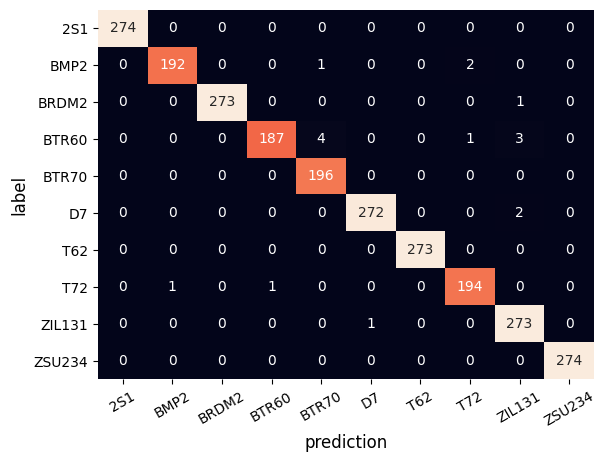

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

m.load(best_path)
_conf_mat = confusion_matrix(m, test_set)

sns.reset_defaults()
ax = sns.heatmap(_conf_mat, annot=True, fmt='d', cbar=False)
ax.set_yticklabels(mstar.target_name_soc, rotation=0)
ax.set_xticklabels(mstar.target_name_soc, rotation=30)

plt.xlabel('prediction', fontsize=12)
plt.ylabel('label', fontsize=12)


plt.show()

### Noise Simulation

In [9]:
from skimage import util


def generate_noise(_images, amount):
    
    n, _, h, w = _images.shape
        
    noise = np.array([np.random.uniform(size=(1, h, w)) for _ in range(n)])
    portions = np.array([
        util.random_noise(np.zeros((1, 88, 88)), mode='s&p', amount=amount)
        for _ in range(n)
    ])
    noise = noise * portions
        
    return _images + noise.astype(np.float32)


def noise_simulation(_m, ds, noise_ratio):
    
    num_data = 0
    corrects = 0
    
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels = data
        images = generate_noise(images, noise_ratio)

        predictions = _m.inference(images)
        predictions = _softmax(predictions)

        _, predictions = torch.max(predictions.data, 1)
        labels = labels.type(torch.LongTensor)
        num_data += labels.size(0)
        corrects += (predictions == labels.to(m.device)).sum().item()

    accuracy = 100 * corrects / num_data
    
    return accuracy

In [10]:
noise_result = {}

for ratio in [0.01, 0.05, 0.10, 0.15]:
    noise_result[ratio] = noise_simulation(m, test_set, ratio)
    print(f'ratio = {ratio:.2f}, accuracy = {noise_result[ratio]:.2f}')


ratio = 0.01, accuracy = 98.97
ratio = 0.05, accuracy = 95.71
ratio = 0.10, accuracy = 88.58
ratio = 0.15, accuracy = 76.95


In [ ]:
test_set = load_dataset('dataset', False, 'eoc-1', 100)
m.load(best_path)
_conf_mat = confusion_matrix(m, test_set)

sns.reset_defaults()
ax = sns.heatmap(_conf_mat, annot=True, fmt='d', cbar=False)
ax.set_yticklabels(mstar.target_name_soc, rotation=0)
ax.set_xticklabels(mstar.target_name_soc, rotation=30)

plt.xlabel('prediction', fontsize=12)
plt.ylabel('label', fontsize=12)


plt.show()

load test data set: 1151it [00:00, 2098.24it/s]
